In [485]:
import os                                                              
import time   
import pickle
import sys
import numpy as np                                                     
import pandas as pd   
import seaborn as sns                                                  
import matplotlib.pyplot as plt                                        
                                                                       
from sklearn.metrics import mean_absolute_error                        
from sklearn.metrics import mean_squared_error                         
from sklearn.model_selection import train_test_split                   
from sklearn.preprocessing import StandardScaler                       
from sklearn.model_selection import train_test_split                   

import ase                                                             
import ase.build                                                       
from ase import Atoms                                                  
from ase.atoms import Atoms                                            
from ase.io import read, write                                         
from ase.calculators.dftb import Dftb                                  
from ase.units import Hartree, mol, kcal, Bohr                         
                                                                       
from Calculator import src_nogrd                                                       
from Calculator.src_nogrd import sym_func_show                                    
from Calculator.src_nogrd import xyzArr_generator                                 
from Calculator.src_nogrd import feat_scaling_func                                
from Calculator.src_nogrd import at_idx_map_generator
from Calculator.src_nogrd import at_idx_map_generator_old
                                                                                                                           
import pickle
from itertools import combinations_with_replacement as comb_replace
                                                                       
import Utils.DirNav                                                
from Utils.dftb_traj_io import read_scan_traj

In [486]:
root_dir = 'C:\\Users\\Tysh\\Desktop\\'

geom_filename          = os.path.join(root_dir,'Au79.xyz')
md_train_arr_origin    = read_scan_traj(filename=geom_filename)
md_train_arr = md_train_arr_origin.copy(deep=False).reset_index(drop=True)

In [487]:
nAtoms, xyzArr = xyzArr_generator(md_train_arr)# Calculate distance dataframe from xyz coordinates
distances = src_nogrd.distances_from_xyz(xyzArr, nAtoms)

In [488]:
struct = ase.io.read(geom_filename, format = "xyz")
SUPPORTED_ELEMENTS = list(dict.fromkeys(struct.get_chemical_symbols()))

In [489]:
list(dict.fromkeys(struct.get_atomic_numbers()))

[79, 8, 1]

In [490]:
lst=list(range(0, nAtoms))

In [491]:
import itertools
def find_tuples(lst, key, num=3):
    return [i for i in itertools.permutations(lst, num) if sum(i)==key]
angles=find_tuples(lst,nAtoms,3)

In [492]:
all_ang=[]
for j in range(0,len(md_train_arr)):
    for i in range (0,nAtoms):
        all_ang.append(md_train_arr[j].get_angle(*angles[i]))

In [493]:
cutoff_rad = max(distances.max(1))
Rs_array = np.linspace(distances.min(1), max(distances.max(1)), num=int(max(distances.max(1))-min(distances.min(1))))   # based on max and min of the distances
eta_array = (int(max(distances.max(1))-min(distances.min(1))))/(2*np.square(min(distances.min(1))*Rs_array))
rad_params = np.array([(Rs_array[i], eta_array[i], cutoff_rad) for i in range(len(Rs_array)) ])



# angular symmetry function parameters
cutoff_ang = math.radians(max(all_ang))
lambd_array = np.array([-1, 1])
#zeta_array = np.array([1, 4, 16])
zeta_array = np.array([math.radians(sum(all_ang)/len(all_ang))])
#eta_ang_array = np.array([0.001, 0.01, 0.05])
eta_ang_array = np.array([math.radians(min(all_ang))])

# Each of the element need to be parametrized for all of the list. 
angList = np.array([e1+e2 for e1, e2 in comb_replace(SUPPORTED_ELEMENTS, 2)])
print(angList)
ang_comp = {el : angList for el in SUPPORTED_ELEMENTS}
ang_params = np.array([[eta, zeta, lambd, cutoff_ang] for eta in eta_ang_array for zeta in zeta_array for lambd in lambd_array])

['AuAu' 'AuO' 'AuH' 'OO' 'OH' 'HH']


In [495]:
np.array([e1+e2 for e1, e2 in comb_replace(SUPPORTED_ELEMENTS, 2)])

array(['AuAu', 'AuO', 'AuH', 'OO', 'OH', 'HH'], dtype='<U4')

In [496]:
at_idx_map = at_idx_map_generator_old(md_train_arr[0])

In [497]:
Gparam_dict = {}
for at_type in at_idx_map.keys():
   Gparam_dict[at_type] = {}
   Gparam_dict[at_type]['rad'] = {}
   for at2_rad in at_idx_map.keys():
           Gparam_dict[at_type]['rad'][at2_rad] = rad_params

   # This Section is already designed to be genera
   Gparam_dict[at_type]['ang'] = {}
   for at23_ang in ang_comp[at_type]:
       Gparam_dict[at_type]['ang'][at23_ang] = ang_params
for at_type in Gparam_dict.keys():
   print(Gparam_dict[at_type]['rad'].keys())

dict_keys(['Au', 'O', 'H'])
dict_keys(['Au', 'O', 'H'])
dict_keys(['Au', 'O', 'H'])


In [498]:
def cutoff(Rc, Rij):
    """ Cutoff function for both angular and radial symmetry function
        Args:
            Rc: the cutoff radius
            Rij: (arr) distance between two atoms of index i and j.

        Outputs:
            cutoff_arr: the value of the cut off function
            f = 0.5 * (Cos[ pi * Rij / Rc] + 1)

    """
    const = 1 / Rc

    cutoff_arr = 0.5 * ( np.cos( np.pi * Rij * const ) + 1) *  (Rij < Rc)

    return cutoff_arr


def radial_filter(Rs, eta, Rij):
    """radial filter for symmetry functions
    # Arguments
        Rs, eta: radial symmetry function parameters; float
        Rij: distance values between two given atoms i and j;
                1D numpy array of length Nsamples

    # Returns
        G_rad_ij: radial filter values; 1D numpy array of length nb_samples
    """
    G_rad_ij = np.exp(-eta * (Rij-Rs)**2)
    return G_rad_ij

def angular_filter(Rij, Rik, Rjk, eta, zeta, lambd):
    """angular filter for angular symmetry functions
    # Arguments
        eta, zeta, lambd: angular symmetry function parameters
        Rij, Rik, Rjk: distances among three atoms i, j, k; 1D arrays of length nb_samples

    # Returns
        G_ang_ij: angular filter values; 1D numpy array of length nb_samples

    """
    cos_angle = (Rij**2 + Rik**2 - Rjk**2)/(2.0 * Rij * Rik)
    rad_filter = np.exp(-eta*(Rij + Rik + Rjk)**2)
    G_ang_ijk = 2**(1.0-zeta) * (1.0 + lambd * cos_angle)**zeta * rad_filter


    return G_ang_ijk

In [499]:
    #pdb.set_trace()
    Nsamples = distances.shape[0]
    Gfunc_data = pd.Series([])

    # This for loop goes through elements
    # Are together
    for at_type in at_idx_map.keys():
        Gparam_rad = Gparam_dict[at_type]['rad']
        Gparam_ang = Gparam_dict[at_type]['ang']

        Gfunc_data[at_type] = pd.Series([])

        rad_count = sum([Gparam_rad[t].shape[0] for t in Gparam_rad.keys()])
        ang_count = sum([Gparam_ang[t].shape[0] for t in Gparam_ang.keys()])


        ## This for loop goes through all the atoms (belong to the same element)
        for at1 in at_idx_map[at_type]:
            Gfunc_data[at_type][at1] = np.zeros((Nsamples, rad_count + ang_count))

            G_temp_count = 0

            # radial components
            for at2_type in Gparam_rad.keys():
                comp_count =  Gparam_rad[at2_type].shape[0]
                G_temp_component = np.zeros((Nsamples, comp_count))

                for count, values in enumerate(Gparam_rad[at2_type]):
                    #pdb.set_trace()
                    for at2 in at_idx_map[at2_type][at_idx_map[at2_type]!=at1]:
                        # Problem Located: The following code does not work.
                        # The dist does not put into the allowance.
                        dist = tuple(sorted([at1, at2]))
                        #pdb.set_trace()
                        R12_array = distances[dist].values[:Nsamples]
                        # values[0] = Rs, values[1] = eta (integer, not array), values[2] = Rc (cutoff)
                        # Then Calculate the radial symmetric function -> value of G.
                        rad_temp = radial_filter(values[0], values[1], R12_array) * cutoff(values[2], R12_array)
                        G_temp_component[:,count] += rad_temp

                Gfunc_data[at_type][at1][:,G_temp_count:G_temp_count+comp_count] = G_temp_component
                G_temp_count += comp_count

            # ======================
            # angular components
            for atAatB_type in Gparam_ang.keys():
                comp_count = Gparam_ang[atAatB_type].shape[0]
                G_temp_component = np.zeros((Nsamples, comp_count))
                                # This for loop goes through all 'HH', 'HO' combo?
            for count, values in enumerate(Gparam_ang[atAatB_type]):
                    atA_list = at_idx_map[atAatB_type[0]][at_idx_map[atAatB_type[0]]!=at1]
                    for atA in atA_list:
                        dist_1A = tuple(sorted([at1, atA]))
                        R1A_array = distances[dist_1A].values[:Nsamples]

                        if atAatB_type[0] == atAatB_type[1]:
                            atB_list = at_idx_map[atAatB_type[1]][(at_idx_map[atAatB_type[1]]!=at1) & (at_idx_map[atAatB_type[1]]>atA)]
                        else:
                            atB_list = at_idx_map[atAatB_type[1]][(at_idx_map[atAatB_type[1]]!=at1)]

                        for atB in atB_list:
                            dist_1B = tuple(sorted([at1, atB]))
                            dist_AB = tuple(sorted([atA, atB]))
                            R1B_array = distances[dist_1B].values[:Nsamples]
                            RAB_array = distances[dist_AB].values[:Nsamples]

                            if np.any(R1B_array == 0):
                                import pdb; pdb.set_trace()
                            if np.any(RAB_array == 0):
                                import pdb; pdb.set_trace();
                            ang_temp = angular_filter(R1A_array, R1B_array, RAB_array, values[0], values[1], values[2]) \
                                        * cutoff(values[3], R1A_array) * cutoff(values[3], R1B_array) * cutoff(values[3], RAB_array)

                            G_temp_component[:, count] += ang_temp
            Gfunc_data[at_type][at1][:,G_temp_count:G_temp_count+comp_count] = G_temp_component
            G_temp_count += comp_count

<ipython-input-499-21b380972b51>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Gfunc_data = pd.Series([])
<ipython-input-499-21b380972b51>:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Gfunc_data[at_type] = pd.Series([])


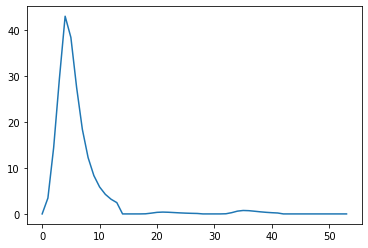

In [500]:
plt.plot(Gfunc_data[SUPPORTED_ELEMENTS[0]][0][0])

In [501]:
n_symm_func =Gfunc_data[SUPPORTED_ELEMENTS[0]][0][0].shape[0]
print(n_symm_func)

54
